In [39]:
import torch
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime
import skimage.color
import skimage.filters
import skimage.exposure
from skimage import feature, measure
from skimage.draw import line
from skimage.transform import probabilistic_hough_line
from scipy.spatial import distance
from scipy.ndimage import convolve
from scipy.signal import convolve2d

import time
import math

import cv2
import csv
import ast
import os


#testing with sample image to see if indeed we get potential vanishing points

In [40]:
image = cv2.imread("image.jpg")

Testing using Hough transform

/tmp/ipykernel_26370/1450652176.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
/tmp/ipykernel_26370/1450652176.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  y1 = (dist - gray.shape[1] * np.cos(angle)) / np.sin(angle)


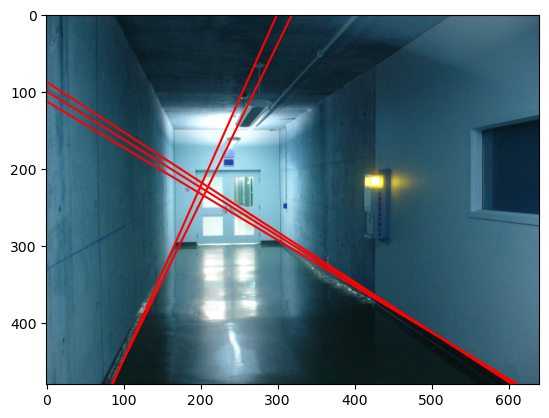

In [41]:
import cv2
import numpy as np
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread("image.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Edge detection using skimage
edges = feature.canny(gray, sigma=3)

# Line detection using Hough Transform in skimage
h, theta, d = hough_line(edges)

# Find peaks in the Hough space to get lines
peaks = hough_line_peaks(h, theta, d, threshold=0.5 * h.max())

# Filter and draw the lines
for _, angle, dist in zip(*peaks):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - gray.shape[1] * np.cos(angle)) / np.sin(angle)
    plt.plot((0, gray.shape[1]), (y0, y1), '-r')



plt.imshow(image)
plt.show()


Attempting to check lines using contour method

/tmp/ipykernel_26370/4094097452.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(x - 100)
/tmp/ipykernel_26370/4094097452.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(m * (x - 100) + b)
/tmp/ipykernel_26370/4094097452.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(x + 100)
/tmp/ipykernel_26370/4094097452.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. E

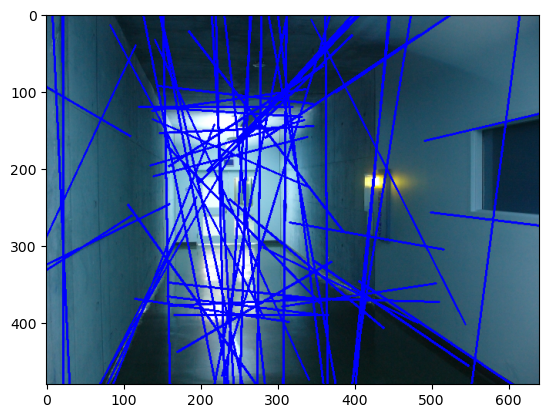

In [42]:


# Load an image
image = cv2.imread("image.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a basic edge detection algorithm
edges = cv2.Canny(gray, threshold1=50, threshold2=150)

# Find contours using the edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to store line segments
lines = []

# Set a minimum length threshold for detected lines
min_line_length = 20

# Iterate through the contours
for contour in contours:
    if len(contour) >= min_line_length:
        # Fit a line to the contour using the least-squares method
        vx, vy, x, y = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
        m = vy / vx
        b = y - m * x
        x1 = int(x - 100)
        y1 = int(m * (x - 100) + b)
        x2 = int(x + 100)
        y2 = int(m * (x + 100) + b)
        lines.append((x1, y1, x2, y2))

# Draw the detected lines
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(image)
plt.show()


Beginning of Acculumation step, going with contour method as it seems to give  good results based on the computational power accessable

/tmp/ipykernel_26370/3661739506.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(x - 100)
/tmp/ipykernel_26370/3661739506.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(m * (x - 100) + b)
/tmp/ipykernel_26370/3661739506.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(x + 100)
/tmp/ipykernel_26370/3661739506.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. E

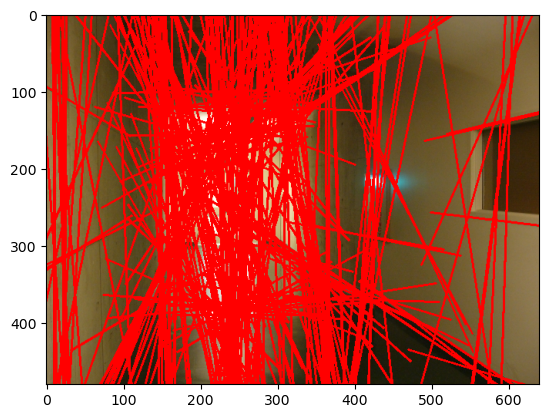

In [43]:


def detect_lines(image, min_line_length=5,visualize = False):
    """
    Detect lines in an image, return line coordinates, and visualize the lines.

    Args:
        image_path (str): Path to the input image.
        min_line_length (int): Minimum length threshold for detected lines.
        visualize(bool): Default False
    Returns:
        lines (list): List of line coordinates as tuples (x1, y1, x2, y2).
        is_infinite (list): List of boolean values indicating whether each line is at infinity.
        image_with_lines (ndarray): The input image with detected lines drawn on it.
    """
    #print(image.shape)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a basic edge detection algorithm
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)

    # Find contours using the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize lists to store line segments and their infinity status
    lines = []
    is_infinite = []
    image_with_lines=[]
    if (visualize):
        # Create a copy of the original image to draw lines on
        image_with_lines = image.copy()

    # Iterate through the contours
    for contour in contours:
        if len(contour) >= min_line_length:
            # Fit a line to the contour using the least-squares method
            vx, vy, x, y = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
            m = vy / vx if vx != 0 else np.inf  # Calculate slope and handle vertical lines

            if np.isinf(m):
                is_infinite.append(True)
            else:
                is_infinite.append(False)

            b = y - m * x
            x1 = int(x - 100)
            y1 = int(m * (x - 100) + b)
            x2 = int(x + 100)
            y2 = int(m * (x + 100) + b)

            lines.append((x1, y1, x2, y2))
            if visualize == True:
            # Draw the line on the image
                cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)
    if (visualize):
        return lines, is_infinite, image_with_lines
    else:
        return lines, is_infinite
# Example usage:
lines, is_infinite,image_with_lines = detect_lines(image,min_line_length=20,visualize = True)
'''
for i, line in enumerate(lines):
    print(f"Line {i + 1}: {line} (Is Infinite: {is_infinite[i]})")
    '''
#print(image_with_lines)
# Display the image with detected lines
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.show()


In [44]:
def find_intersections(lines, image):
    # Read the input image
    
    image_with_intersections = image.copy()  # Create a copy of the original image

    height, width, _ = image.shape  # Get image dimensions

    # Initialize a list to store the intersection points
    intersections = []

    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            # Extract line coordinates
            x1, y1, x2, y2 = lines[i]
            x3, y3, x4, y4 = lines[j]

            # Calculate the intersection point
            det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

            if det != 0:
                px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
                py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det

                intersection_point = (px, py)

                
                intersections.append(intersection_point)

    

    return intersections

# Example usage:
intersections = find_intersections(lines, image)


In [45]:
for i in range(1000):
  print(intersections[i])

(154.74994705633208, 314.70992164337144)
(144.9222200883426, 337.4766660265028)
(283.0550172775933, 17.480588115725997)
(159.01491598788286, 304.8297674853568)
(129.8181818181818, 372.46642302421196)
(367.32358268211686, -177.73453073595917)
(248.5050166741255, 97.51852921220171)
(221.20235465007755, 160.7674095794686)
(227.59414970413786, 145.9602863637811)
(180.06060606060606, 256.07568143749046)
(255.5399249792233, 81.22158082702545)
(281.09371809147325, 22.024100300657512)
(210.61867850984436, 185.28537289930526)
(171.48147223064709, 275.9499562898075)
(30.96600677259703, 601.4656828031798)
(212.15372408575803, 181.729312545053)
(299.6138130642903, -20.879235289637272)
(278.16186659044513, 28.815977396003987)
(332.7157968374038, -97.56272533690029)
(286.3440594884791, 9.861249124679048)
(287.49982424915333, 7.1838242268357595)
(318.21052204325446, -63.96005357758941)
(231.66253992793546, 136.53552308151637)
(167.34902997942967, 285.5231014044368)
(167.39802147965412, 285.4096085320

In [46]:
def calculate_line_length(x1, y1, x2, y2):
    # Ensure the arguments are treated as floating-point numbers
    x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return length


def point_to_line_distance(x, y, x1, y1, x2, y2):
    # Calculate the distance from a point to a line defined by (x1, y1) and (x2, y2)
    line_length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    mask = (line_length != 0)
    distance = np.where(mask, np.abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1) / line_length, np.sqrt((x - x1) ** 2 + (y - y1) ** 2))
    return distance

In [47]:
def is_point_on_line(x, y, x1, y1, x2, y2, tolerance=1e-6):
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    expected_y = m * x + b
    return (abs(y - expected_y) < tolerance)

In [88]:
def calculate_vanishing_point_votes(lines, is_infinite, intersections, w1=0.3, w2=0.7, ta=5):
    vanishing_point_votes = []
    
    # Calculate maximum length only once
    max_length = max(calculate_line_length(x1, y1, x2, y2) for x1, y1, x2, y2 in lines)
    
    for point in intersections:
        x, y = point
        votes = 0
        
        for x1, y1, x2, y2 in lines:
            if is_point_on_line(x, y, x1, y1, x2, y2):
                distance = point_to_line_distance(x, y, x1, y1, x2, y2)
                vote = (w1 * (1 - distance / ta)) + w2 * (calculate_line_length(x1, y1, x2, y2) / max_length)
                votes += vote
        
        vanishing_point_votes.append([x, y, votes])
    
    return vanishing_point_votes


In [49]:
vanishing_point_votes = calculate_vanishing_point_votes(lines,is_infinite,intersections)
print(vanishing_point_votes[0])

[154.74994705633208, 314.70992164337144, 0.600805171323934]


In [50]:
#print(vote_calc(lines,is_infinite,intersections))

In [51]:
print(intersections[0])

(154.74994705633208, 314.70992164337144)


In [52]:
lengths = [calculate_line_length(x1, y1, x2, y2) for x1, y1, x2, y2 in lines]
print(max(lengths))

747103.0267700701


In [53]:

def calculate_angle(ai,aj):
    # Calculate the angle in degrees between two points with respect to the x-axis
		dx, dy, _ = np.array(ai) - np.array(aj)
		angle_degrees = np.degrees(np.arctan2(dy, dx))
		return angle_degrees

In [54]:
def calculate_distance_and_angle(ai,aj):
    x1,y1,_ = ai
    x2,y2,_ = aj
    distance=calculate_line_length(x1,y1,x2,y2)
    angle=calculate_angle(ai,aj)
    return distance, angle

In [55]:
def _vanishing_line_criterion_(ai,aj,td,talpha):

		# Use the distance function to get distance and angle
		distance, angle = calculate_distance_and_angle(ai, aj)
		#print(distance,angle)
		# Check if the distance and angle are below the thresholds
		if distance < td and angle < talpha:
			return True  # The vanishing point criterion is fulfilled
		return False  # The vanishing point criterion is not fulfilled

In [56]:
def calculate_slope(ai,aj):
    x1,y1,_ = ai
    x2,y2,_ = aj
    # Check for division by zero to avoid errors
    if x1 == x2:
        return "Undefined (Vertical Line)"
    else:
        return (y2 - y1) / (x2 - x1)

In [57]:
import math


def are_points_collinear(a1, ai, aj, tolerance=1e-6):
    # Calculate the determinant of the matrix formed by the points
    matrix = np.array([[a1[0], a1[1], 1],
                       [ai[0], ai[1], 1],
                       [aj[0], aj[1], 1]])
    
    det = np.linalg.det(matrix)
    
    # Points are collinear if the determinant is close to zero
    return abs(det) < tolerance

def orthoganality_camera_criterion(a1, ai, aj, point_difference_max, image_mid):
    if are_points_collinear(a1, ai, aj):
        
        return False

    # Calculate the lengths of the sides and angles (as before)
    dAB = calculate_line_length(a1[0], a1[1], ai[0], ai[1])
    dBC = calculate_line_length(ai[0], ai[1], aj[0], aj[1])
    dCA = calculate_line_length(a1[0], a1[1], aj[0], aj[1])

    
    if dAB + dBC > dCA and dAB + dCA > dBC and dBC + dCA > dAB:
        angle1 = math.degrees(math.acos((dBC**2 + dCA**2 - dAB**2) / (2 * dBC * dCA)))
        angle2 = math.degrees(math.acos((dCA**2 + dAB**2 - dBC**2) / (2 * dCA * dAB)))
        angle3 = math.degrees(math.acos((dAB**2 + dBC**2 - dCA**2) / (2 * dAB * dBC)))

        centroid = ((a1[0] + ai[0] + aj[0]) / 3, (a1[1] + ai[1] + aj[1]) / 3)
    
        image_mid_x, image_mid_y = image_mid
        difference_principal_midpoint = calculate_line_length(centroid[0], centroid[1], image_mid_x, image_mid_y)

        if angle1 < 90 and angle2 < 90 and angle3 < 90 and difference_principal_midpoint < point_difference_max:
            return True

    return False




In [58]:
print(vanishing_point_votes[0][2])

0.600805171323934


Search step 

In [59]:
def search_step(image_path,lines,vanishing_point_votes,td=100,talpha=30,max_vote=-2000):
  img = cv2.imread(image_path)
  #print(img.shape)
  height, width,_ = img.shape
  image_mid=(width//2,height//2)
  #print(image_mid)
  point_difference_max=(math.sqrt(width**2 + height**2)*.43)
  #print(point_difference_max)
  # Find the item with the maximum votes
  a1 = max(vanishing_point_votes, key=lambda item: item[2])
  #print(a1)
  # Create a list without the item with maximum votes
  eligible_votes = [item for item in vanishing_point_votes if item != a1]
  tries = 5000
  aiF= eligible_votes[0]
  ajF= eligible_votes[1]
  ai= eligible_votes[0]
  aj= eligible_votes[1]
  best_vote = a1[2] + ai[2] + aj[2]
  for i in range(tries):
    random_indices = random.sample(eligible_votes, 2)
    ai,aj= random_indices

    #print(a1,ai,aj)
    #print(_vanishing_line_criterion_(a1,ai,td,talpha),_vanishing_line_criterion_(ai,aj,td,talpha),_vanishing_line_criterion_(a1,aj,td,talpha))
    if _vanishing_line_criterion_(a1,ai,td,talpha) and _vanishing_line_criterion_(ai,aj,td,talpha) and _vanishing_line_criterion_(a1,aj,td,talpha):
      #print("vanishing criterion passed")
      if orthoganality_camera_criterion(a1,ai,aj,point_difference_max,image_mid):
        #print("orthoganality camera passed")
        final_vote = a1[2] + ai[2] + aj[2]
        if final_vote > best_vote:
          aiF=ai
          ajF=aj
        #print(a1,ai,aj)
        if final_vote > max_vote:
          #print(final_vote)
          #print(a1,ai,aj)
          aiF=ai
          ajF=aj
          tries=tries-1
          break
  if tries > 0:
    # Define the 2D points as a list of (x, y) coordinates
    ai=aiF
    aj=ajF
    

    return a1,ai,aj,True
  else:
    return 0,0,0,False
  pass

In [60]:
image_path="image.jpg"
a1,ai,aj,_ = search_step(image_path,lines,vanishing_point_votes)

Testing out the Search step and the final result by hand for a sample image

In [61]:
image = cv2.imread("image.jpg")

195.40927037311795 226.21455074363982


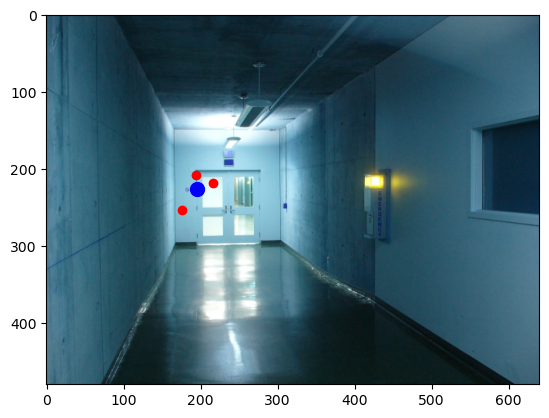

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the 2D points as a list of (x, y) coordinates
points = [(a1[0], a1[1]), (ai[0],ai[1]), (aj[0],aj[1])]


# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Plot the 2D points on the image
for point in points:
    x, y = point
    ax.plot(x, y, 'ro')  # 'ro' for red circles

# Plot the midpoint as a blue circle
if points:
        x_coords, y_coords = zip(*points)
        centroid_x = sum(x_coords) / len(x_coords)
        centroid_y = sum(y_coords) / len(y_coords)

        # Plot the centroid
        ax.plot(centroid_x, centroid_y, 'bo', markersize=10)
        
        print(centroid_x, centroid_y)


# Show the image with the plotted points and midpoint
plt.show()


In [63]:
import zipfile

zip_file_path = "./data/YorkUrbanDB.zip"  # Replace with the path to ZIP file
extracted_dir = "./data/"  

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)


In [64]:
import scipy.io
mat = scipy.io.loadmat('./data/YorkUrbanDB/P1040811/P1040811LinesAndVP.mat')
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Fri May 11 15:16:22 2007', '__version__': '1.0', '__globals__': [], 'lines': array([[635.825, 131.575],
       [554.625, 148.775],
       [636.9  , 276.25 ],
       [548.55 , 265.4  ],
       [279.275, 202.525],
       [194.675, 202.825],
       [304.25 , 293.4  ],
       [279.725, 294.425],
       [195.4  , 296.2  ],
       [168.575, 296.575],
       [302.4  , 150.55 ],
       [167.425, 150.625],
       [167.475, 150.625],
       [169.45 , 296.45 ],
       [303.525, 152.025],
       [304.6  , 293.35 ],
       [427.4  , 364.6  ],
       [427.45 ,  67.7  ],
       [ 74.6  , 474.65 ],
       [ 65.55 ,   3.   ],
       [203.425, 212.525],
       [204.45 , 288.05 ],
       [269.9  , 211.8  ],
       [270.55 , 286.55 ],
       [230.375, 210.525],
       [230.775, 288.675],
       [244.525, 212.625],
       [245.475, 287.525],
       [203.225, 211.425],
       [270.6  , 211.65 ],
       [204.375, 288.525],
       [271.225, 28

generate a csv with dataset values

In [65]:
%run ./dataloader_vp_.py


/home/anusha/Documents/projects/uni-heidelberg/3d reconstruction/computer-vision-3D-reconstruction/dataloader_vp_.py:68: RuntimeWarning: overflow encountered in scalar subtract
  det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
/home/anusha/Documents/projects/uni-heidelberg/3d reconstruction/computer-vision-3D-reconstruction/dataloader_vp_.py:68: RuntimeWarning: overflow encountered in scalar multiply
  det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
/home/anusha/Documents/projects/uni-heidelberg/3d reconstruction/computer-vision-3D-reconstruction/dataloader_vp_.py:70: RuntimeWarning: overflow encountered in scalar subtract
  px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
/home/anusha/Documents/projects/uni-heidelberg/3d reconstruction/computer-vision-3D-reconstruction/dataloader_vp_.py:70: RuntimeWarning: overflow encountered in scalar multiply
  px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
/home/anusha/Documents

[[(207.39980056311651, 214.36772641952052), (5006.512300339003, 227.4656625985343), (574.2212561524693, -15077.418585715039)], 'P1040811.jpg']
[[(0.9342806394316163, 3.6394316163410303), (0.9032070683909628, 0.5378030511480021), (14.056154282473058, 18.32161089052751)], 'P1020816.jpg']
[[(454.8141803524189, 285.20147880996376), (162.87518422532344, -11534.519579403546)], 'P1040815.jpg']
[[(-931.8559197324643, 277.43874916387955), (52.0668285127134, 6335.51578199791), (948.1809882407733, 291.50620592444426)], 'P1040779.jpg']
[[(22.256085177328256, 213.565451652015), (232.3894101199856, -9939.011189857232), (1231.8138900937108, 272.91067227887686)], 'P1080096.jpg']
[[(-1841.4142148808828, 256.54870613777723), (512.8218849155796, 279.47183280450224), (101.29204137141888, -1149.8991925446933)], 'P1040825.jpg']
[[(144.1139740221716, 170.56515615878197), (64.02900840544406, -2572.568452559876)], 'P1020171.jpg']
[[(-210.58465516345643, 61.50496597093238), (1226.8119535456826, 105.574456968148

In [66]:
#print(filename_list)

In [67]:
img_path= "P1020177.jpg"
image = cv2.imread("image.jpg")

In [68]:
def _sample_hypothsis_(image):
    # Example usage:
    lines, is_infinite = detect_lines(image,min_line_length=20,visualize = False)
    intersections = find_intersections(lines, image)
    vanishing_point_votes = calculate_vanishing_point_votes(lines,is_infinite,intersections)
    a1,ai,aj,success = search_step(image_path,lines,vanishing_point_votes)
    points = [(a1[0], a1[1]), (ai[0],ai[1]), (aj[0],aj[1])]

    if points:
            x_coords, y_coords = zip(*points)
            centroid_x = sum(x_coords) / len(x_coords)
            centroid_y = sum(y_coords) / len(y_coords)
            centroid=[centroid_x, centroid_y]

    return centroid,success

quick test of the function with another image

In [69]:
_sample_hypothsis_(image)

/tmp/ipykernel_26370/3661739506.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(x - 100)
/tmp/ipykernel_26370/3661739506.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(m * (x - 100) + b)
/tmp/ipykernel_26370/3661739506.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(x + 100)
/tmp/ipykernel_26370/3661739506.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. E

([92.54124257942085, -26492.8185789558], True)

data loaders

In [70]:
csv_file = "data.csv"

In [71]:
def data(csv_file):
    data_set=[]
    lables=[]
    img_path=[]
    # Read and parse the CSV file
    with open(csv_file, newline='') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # Parse the string representation of the points using ast.literal_eval
            points = ast.literal_eval(row[0])

            # Extract the filename
            filename = row[1]
            filename, _ = os.path.splitext(filename)
            filename = "./data/YorkUrbanDB" + "/" + filename + "/" + filename + ".jpg"
            
            img_path.append(filename)
            # Load the image
            img = cv2.imread("image.jpg")
            if img is not None:
                 
                data_set.append(img)
            # Calculate the centroid of the points and add and ground truth
            if points:
                x_coords, y_coords = zip(*points)
                centroid_x = sum(x_coords) / len(x_coords)
                centroid_y = sum(y_coords) / len(y_coords)
                centroid=[centroid_x,centroid_y]
                lables.append(centroid)
            
                
    return data_set,lables

In [72]:
csv_file = "data.csv"
images,lables = data(csv_file)
print(images[0])
print(len(images))
print(len(lables))


[[[ 43  84 107]
  [ 47  88 111]
  [ 53  89 113]
  ...
  [ 69  99 118]
  [ 67 100 116]
  [ 66  99 115]]

 [[ 41  83 106]
  [ 45  86 109]
  [ 50  88 112]
  ...
  [ 66  98 117]
  [ 67 101 117]
  [ 65  99 115]]

 [[ 35  79 103]
  [ 43  87 111]
  [ 45  85 110]
  ...
  [ 62  98 116]
  [ 64 100 118]
  [ 62  98 116]]

 ...

 [[ 81 121 140]
  [ 80 120 139]
  [ 80 118 136]
  ...
  [ 62  97 117]
  [ 60  97 117]
  [ 58  95 115]]

 [[ 78 121 138]
  [ 79 119 137]
  [ 85 121 139]
  ...
  [ 66  99 118]
  [ 65  98 117]
  [ 61  94 113]]

 [[ 76 119 134]
  [ 79 120 135]
  [ 83 119 137]
  ...
  [ 65  97 116]
  [ 65  98 114]
  [ 65  98 114]]]
102
102


In [73]:
def splitter(dataset,valsize,use):
    images,lables = dataset
    split_index = int(valsize * len(images))
    if use == "val":
        images1=images[:split_index]
        lables1=lables[:split_index]
    elif use == "train":
        images1=images[split_index:]
        lables1=lables[split_index:]
    return images1,lables1

In [74]:
images,lables = splitter(data(csv_file),0.3,"train")
print(len(images))

72


loss function

In [75]:
def loss(est,gt):
	'''
	Calculate the loss.

	est -- estimated 
	gt -- ground truth 
	'''
	loss =  np.mean((est - gt) ** 2)
	return loss

Using the same model that was there in ex5 for lines and circles

In [76]:
import torch
import torch.optim as optim
from vll.model.line_nn import LineNN as Model

In [77]:
def default_params(id):
	return {
		'receptivefield': 65,
		'capacity': 4,
		'hypotheses': 64,
		'inlierthreshold': 0.05,
		'inlieralpha': 0.5,
		'inlierbeta': 100.0,
		'learningrate': 0.001,
		'lrstep': 2500,
		'lrstepoffset': 30000,
		'batchsize': 32,
		'trainiterations': 100,
		'storeinterval': 10,
		'valsize': .3,
		'valthresh': 5,
		'use_gpu': False,
		'id': id
	}

In [78]:
def sample_hyp(image_tensor):
    '''
    image_tensor -- an image tensor

    return values:
        centroid -- centroid of all vanishing points
    '''
    image_tensor = image_tensor.to(torch.uint8)

    # Convert the image tensor to a NumPy array
    image = image_tensor.numpy()

    lines, is_infinite = detect_lines(image, min_line_length=20, visualize=False)
    intersections = find_intersections(lines, image)
    vanishing_point_votes = calculate_vanishing_point_votes(lines, is_infinite, intersections)
    a1, ai, aj, success = search_step(image_path, lines, vanishing_point_votes)
    points = [(a1[0], a1[1]), (ai[0], ai[1]), (aj[0], aj[1])]

    if points:
        x_coords, y_coords = zip(*points)
        centroid_x = sum(x_coords) / len(x_coords)
        centroid_y = sum(y_coords) / len(y_coords)
        centroid = [centroid_x, centroid_y]

    return centroid, success  # True indicates success



def soft_inlier_count(true_centroid, pred_centroid, inlier_beta, inlier_thresh):
    '''
    true_centroid -- ground truth of the centroid
    pred_centroid -- centroid of all vanishing points predicted
    inlier_beta -- the beta parameter for the sigmoid function
    inlier_thresh -- the threshold parameter for the sigmoid function
    '''
    # Calculate the distance
    distance = calculate_line_length(true_centroid[0], true_centroid[1], pred_centroid[0], pred_centroid[1])

    # Convert distance to a PyTorch tensor
    distance = torch.Tensor(np.array([distance]))  # Convert to an array first

    # Apply the sigmoid function
    distance = 1 - torch.sigmoid(inlier_beta * (distance - inlier_thresh))

    # Compute the inlier score
    score = torch.sum(distance)

    return score, distance


		

def refine_hyp(centroid, true_answer):
    """
    """
    # Calculate the refined centroid based on the true answer
    refined_centroid = centroid + (true_answer - centroid) * 0.1  

    return refined_centroid


In [79]:
import csv
import ast
import os

def data(csv_file):
    data_paths = []  # Store image paths here
    labels = []
    
    with open(csv_file, newline='') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # Parse the string representation of the points using ast.literal_eval
            points = ast.literal_eval(row[0])

            # Extract the filename
            filename = row[1]
            filename, _ = os.path.splitext(filename)
            filename = "./data/YorkUrbanDB" + "/" + filename + "/" + filename + ".jpg"
            
            data_paths.append(filename)  # Store the image path
            
            # Calculate the centroid of the points and add the ground truth
            if points:
                x_coords, y_coords = zip(*points)
                centroid_x = sum(x_coords) / len(x_coords)
                centroid_y = sum(y_coords) / len(y_coords)
                centroid = [centroid_x, centroid_y]
                labels.append(centroid)
                
    return data_paths, labels


In [80]:
def default_params(task):
    params = {
        'capacity': 64,  # Model capacity
        'receptivefield': 40,  # Receptive field size
        'learning_rate': 0.001,  # Learning rate
        'num_epochs': 10,  # Number of training epochs
        'batch_size': 32,  # Batch size
        'inlier_threshold': 5.0,  # Inlier threshold
        'inlier_beta': 10.0,  # Inlier beta
        'inlier_thresh': 0.5,  # Inlier threshold for soft inlier count
        'weight': 0.5  # Weight for refining hypotheses
    }
    
    if task == "vanishingpoint":
        # Adjust hyperparameters for vanishing point detection task
        params['capacity'] = 128
        params['receptivefield'] = 60

    return params


In [86]:
import cv2
import numpy as np
import torch

def mse_loss(predicted, target):
    return ((predicted[0] - target[0]) ** 2 + (predicted[1] - target[1]) ** 2)


import numpy as np
import torch
import cv2
import os
import datetime
import matplotlib.pyplot as plt

def train_dsac_vanishing_point(params, data_paths, labels, num_iterations=100, inlier_beta=10.0, inlier_thresh=0.5, weight=0.5, num_epochs=10, batch_size=32, output_directory="predictions", model=None, learning_rate=0.01, validation_split=0.2):
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Split data into training and validation
    num_samples = len(data_paths)
    num_val_samples = int(num_samples * validation_split)
    train_data_paths = data_paths[num_val_samples:]
    train_labels = labels[num_val_samples:]
    val_data_paths = data_paths[:num_val_samples]
    val_labels = labels[:num_val_samples]

    if model is None:
        # Create a new model if not provided
        model = Model(params['capacity'], params['receptivefield'])
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    else:
        # Load an existing model and optimizer
        checkpoint = torch.load('model.pth')  # Replace with the correct model file path
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    avg_exp_loss = 0.0
    avg_top_loss = 0.0

    for epoch in range(num_epochs):
        print("Starting epoch", epoch, "in", num_epochs, datetime.now())
        indices = np.arange(len(train_data_paths))
        np.random.shuffle(indices)

        batch_exp_loss = 0.0  
        batch_top_loss = 0.0  


        for i in range(0, len(train_data_paths), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_data_paths = [train_data_paths[idx] for idx in batch_indices]
            batch_labels = [train_labels[idx] for idx in batch_indices]

            for data_path, true_vanishing_point in zip(batch_data_paths, batch_labels):
                img = cv2.imread(data_path)
                if img is not None:
                    image_tensor = torch.Tensor(img)
                    predicted_centroid = torch.zeros(2)
                    initial_loss = mse_loss(predicted_centroid, true_vanishing_point)

                    for iteration in range(num_iterations):
                        centroid, success = sample_hyp(image_tensor)
                        if success:
                            inlier_score, _ = soft_inlier_count(true_vanishing_point, centroid, inlier_beta, inlier_thresh)
                            loss = mse_loss(centroid, true_vanishing_point)
                            expected_loss = initial_loss + (1 - inlier_score) * loss
                            batch_exp_loss += expected_loss

                    refined_centroid = refine_hyp(predicted_centroid, torch.tensor(true_vanishing_point))
                    batch_top_loss += mse_loss(refined_centroid, true_vanishing_point)

                    # Create the output file path
                    output_file = os.path.join(output_directory, os.path.basename(data_path).replace('.jpg', '.txt'))

                    # Save the predicted outcome in a text file
                    with open(output_file, 'w') as f:
                        f.write(f'Prediction for {os.path.basename(data_path)}:\n')
                        f.write(f'x: {refined_centroid[0]}\n')
                        f.write(f'y: {refined_centroid[1]}\n')

            avg_exp_loss += batch_exp_loss / len(batch_data_paths)
            avg_top_loss += batch_top_loss / len(batch_data_paths)

        train_losses.append(avg_exp_loss / (len(train_data_paths) // batch_size))
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_data_path, val_true_vanishing_point in zip(val_data_paths, val_labels):
                val_img = cv2.imread(val_data_path)
                if val_img is not None:
                    val_image_tensor = torch.Tensor(val_img)
                    val_predicted_centroid = torch.zeros(2)

                    for iteration in range(num_iterations):
                        centroid, success = sample_hyp(val_image_tensor)
                        if success:
                            inlier_score, _ = soft_inlier_count(val_true_vanishing_point, centroid, inlier_beta, inlier_thresh)
                            loss = mse_loss(centroid, val_true_vanishing_point)
                            expected_loss = initial_loss + (1 - inlier_score) * loss
                            val_loss += expected_loss

                    val_refined_centroid = refine_hyp(val_predicted_centroid, torch.tensor(val_true_vanishing_point))
                    val_loss += mse_loss(val_refined_centroid, val_true_vanishing_point)

                    # Create the output file path
                    output_file = os.path.join(output_directory, os.path.basename(data_path).replace('.jpg', '.txt'))

                    # Save the predicted outcome in a text file
                    with open(output_file, 'w') as f:
                        f.write(f'Prediction for {os.path.basename(data_path)}:\n')
                        f.write(f'x: {refined_centroid[0]}\n')
                        f.write(f'y: {refined_centroid[1]}\n')

            val_loss /= len(val_data_paths)
            val_losses.append(val_loss)

        # Save the model with the lowest validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 'model.pth')

    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()

    return avg_exp_loss, avg_top_loss





Starting epoch 0 in 5 2023-10-15 04:51:49.186361


/tmp/ipykernel_26370/3661739506.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(x - 100)
/tmp/ipykernel_26370/3661739506.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(m * (x - 100) + b)
/tmp/ipykernel_26370/3661739506.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(x + 100)
/tmp/ipykernel_26370/3661739506.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. E

Starting epoch 1 in 5 2023-10-15 05:03:47.295571
Starting epoch 2 in 5 2023-10-15 05:15:45.736688
Starting epoch 3 in 5 2023-10-15 05:27:47.201520
Starting epoch 4 in 5 2023-10-15 05:40:01.344554


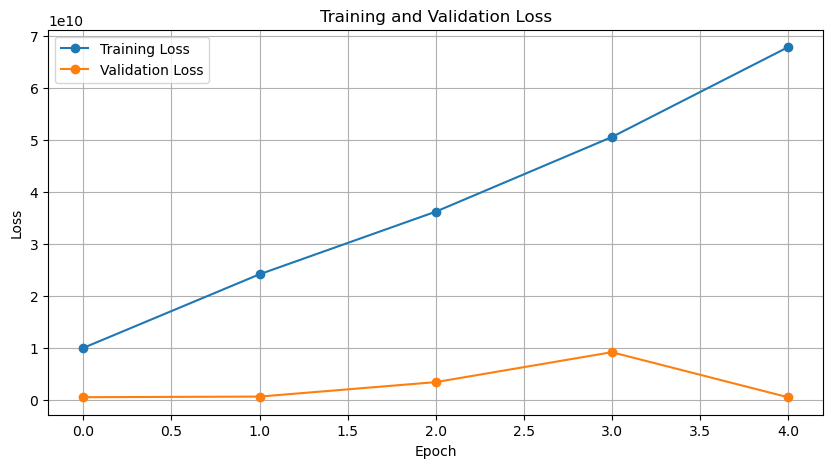

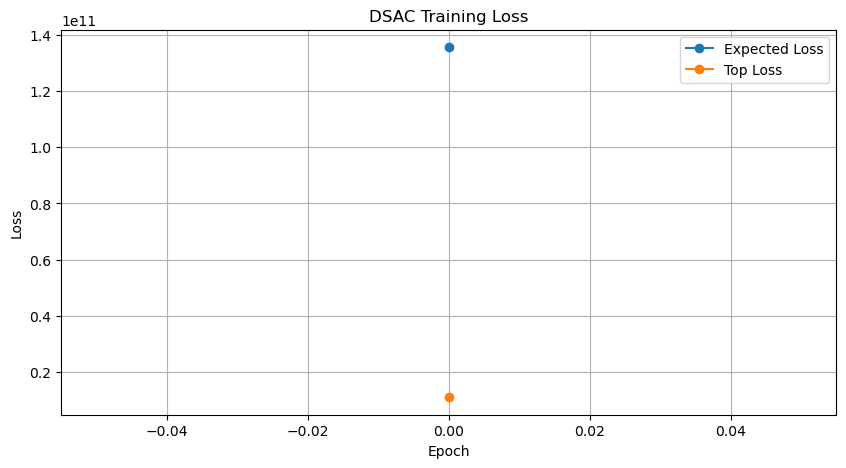

In [90]:
import matplotlib.pyplot as plt
from datetime import datetime

# Load dataset and labels
data_paths, labels = data("data.csv")

# Set hyperparameters for training
params = default_params("vanishingpoint")
output_directory = "predictions"  # Specify the directory to save the predictions

# Train the model and collect loss values
losses = {"exp_loss": [], "top_loss": []}

avg_exp_loss, avg_top_loss = train_dsac_vanishing_point(params,data_paths, labels, num_iterations=5, inlier_beta=10.0, inlier_thresh=0.5, weight=0.5, num_epochs=5, batch_size=32, output_directory="predictions2", model=None, learning_rate=0.01)
losses["exp_loss"].append(avg_exp_loss)
losses["top_loss"].append(avg_top_loss)

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(losses["exp_loss"], label="Expected Loss", marker='o')
plt.plot(losses["top_loss"], label="Top Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("DSAC Training Loss")
plt.grid(True)
plt.show()

